In [1]:
from langchain import OpenAI

In [2]:
llm = OpenAI(temperature=0, openai_api_key="api_key")

In [3]:
prompt = """
Please provide a summary of the following text

TEXT:
Philosophy (from Greek: φιλοσοφία, philosophia, 'love of wisdom') \
is the systematized study of general and fundamental questions, \
such as those about existence, reason, knowledge, values, mind, and language. \
Some sources claim the term was coined by Pythagoras (c. 570 – c. 495 BCE), \
although this theory is disputed by some. Philosophical methods include questioning, \
critical discussion, rational argument, and systematic presentation.
"""

In [4]:
num_tokens = llm.get_num_tokens(prompt)
print (f"Our prompt has {num_tokens} tokens")

Our prompt has 121 tokens


In [5]:
output = llm(prompt)
print (output)


Philosophy is a systematized study of general and fundamental questions about existence, reason, knowledge, values, mind, and language. It is believed to have been coined by Pythagoras, and its methods include questioning, critical discussion, rational argument, and systematic presentation.


In [6]:
prompt = """
Please provide a summary of the following text.
Please provide your output in a manner that a 5 year old would understand

TEXT:
Philosophy (from Greek: φιλοσοφία, philosophia, 'love of wisdom') \
is the systematized study of general and fundamental questions, \
such as those about existence, reason, knowledge, values, mind, and language. \
Some sources claim the term was coined by Pythagoras (c. 570 – c. 495 BCE), \
although this theory is disputed by some. Philosophical methods include questioning, \
critical discussion, rational argument, and systematic presentation.
"""

In [7]:
num_tokens = llm.get_num_tokens(prompt)
print (f"Our prompt has {num_tokens} tokens")

Our prompt has 137 tokens


In [8]:
output = llm(prompt)
print (output)


Philosophy is about asking questions and trying to figure out the answers. It is about thinking about things like existence, knowledge, and values. People have been doing this for a very long time, and it is still done today.


In [9]:
from langchain import OpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [10]:
paul_graham_essay = 'case.txt'

with open(paul_graham_essay, 'r') as file:
    essay = file.read()

In [11]:
llm.get_num_tokens(essay)

560

In [12]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n"], chunk_size=10000, chunk_overlap=500)

docs = text_splitter.create_documents([essay])

In [13]:
num_docs = len(docs)

num_tokens_first_doc = llm.get_num_tokens(docs[0].page_content)

print (f"Now we have {num_docs} documents and the first one has {num_tokens_first_doc} tokens")

Now we have 1 documents and the first one has 560 tokens


In [14]:
summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce',
#                                      verbose=True
                                    )

In [15]:
output = summary_chain.run(docs)

In [16]:
output

' Patrizia was successful in her claim against the Town of Milton and the Region of Halton for negligence in failing to monitor the weather forecasts and ensure the roads were safe, but the defendants appealed the decision. After two years, the Supreme Court of Canada refused leave to appeal, ending the lengthy process for Patrizia.'

In [22]:
from langchain import PromptTemplate


map_prompt = """
Write a concise summary of the following:
"{text}"
CONCISE SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [23]:
combine_prompt = """
Write a concise summary of the following text delimited by triple backquotes.
Return your response in bullet points which covers the key points of the text.
```{text}```
BULLET POINT SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [24]:
summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='map_reduce',
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template,
#                                      verbose=True
                                    )

In [25]:
output = summary_chain.run(docs)

In [26]:
print (output)

- Patrizia was injured in a car accident due to snow-covered roads in Milton
- She brought a claim against the Town of Milton and the Region of Halton for negligence
- After a lengthy trial, Patrizia was successful in establishing her claim, but the defendants appealed the decision
- A Factum was prepared on Patrizia's behalf and the Court of Appeal ruled in her favour
- The defendants asked the Supreme Court of Canada for permission to appeal, but after two years, the Supreme Court of Canada refused leave to appeal, ending the lengthy process for Patrizia


In [30]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader("K.pdf")
pages = loader.load()

pages = pages[:]

text = ""

for page in pages:
    text += page.page_content
    
text = text.replace('\t', ' ')

In [31]:
num_tokens = llm.get_num_tokens(text)

print (f"This book has {num_tokens} tokens in it")

This book has 5708 tokens in it


In [32]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains.summarize import load_summarize_chain
import numpy as np
from sklearn.cluster import KMeans

In [72]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=1000, chunk_overlap=150)

docs = text_splitter.create_documents([text])

In [73]:
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 17 documents


In [74]:
embeddings = OpenAIEmbeddings(openai_api_key="api_key")

vectors = embeddings.embed_documents([x.page_content for x in docs])

In [106]:
num_clusters = 8

kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

In [107]:
kmeans.labels_

array([1, 1, 2, 2, 5, 5, 0, 6, 1, 4, 4, 1, 1, 1, 7, 3, 3], dtype=int32)

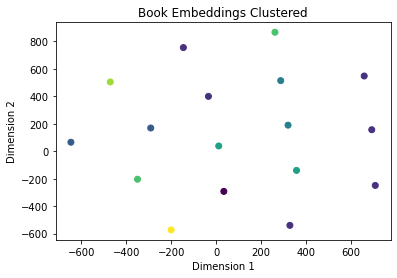

In [108]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(vectors)

plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [109]:
closest_indices = []

for i in range(num_clusters):
    
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    
    closest_index = np.argmin(distances)
    
    closest_indices.append(closest_index)

In [110]:
selected_indices = sorted(closest_indices)
selected_indices

[0, 2, 4, 6, 7, 9, 14, 15]

In [111]:
llm3 = ChatOpenAI(temperature=0,
                 openai_api_key="api_key",
                 max_tokens=1000,
                 model='gpt-3.5-turbo'
                )

In [112]:
map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section so that a reader will have a full understanding of what happened.
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [113]:
map_chain = load_summarize_chain(llm=llm3,
                             chain_type="stuff",
                             prompt=map_prompt_template)

In [114]:
selected_docs = [docs[doc] for doc in selected_indices]

In [122]:
summary_list = []

for i, doc in enumerate(selected_docs):
    
    chunk_summary = map_chain.run([doc])
    
    summary_list.append(chunk_summary)
    
    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:400]} \n")

Summary #0 (chunk #0) - Preview: The case of Kesavananda Bharati v. State of Kerala is a well-known constitutional decision made by the Supreme Court of India. In this case, the court ruled that there is no implied limitation on the powers of Parliament to amend the Constitution. However, it also established the "Basic Structure Doctrine," which states that no amendment can violate the basic structure of the Constitution. This de 

Summary #1 (chunk #2) - Preview: This passage discusses the highly contested issue of the scope and extent of Parliamentary power to modify the Constitution in India. The Golak Nath judgment, mentioned in the passage, was a Supreme Court decision that stated Parliament did not have the power to amend the fundamental rights under Part III of the Indian Constitution. This decision was met with criticism, with many considering it a  

Summary #2 (chunk #4) - Preview: In this passage, it is mentioned that the Constitution (25th Amendment) Act, 1971 modified Arti

In [123]:
summaries = "\n".join(summary_list)

summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 1950 tokens


In [146]:
llm4 = ChatOpenAI(temperature=0,
                 openai_api_key="api_key",
                 max_tokens=1000,
                 model='gpt-3.5-turbo',
                 request_timeout=120
                )

In [147]:
combine_prompt = """
You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [148]:
reduce_chain = load_summarize_chain(llm=llm4,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
#                              verbose=True 
                                   )

In [150]:
output = reduce_chain.run([summaries])

In [151]:
print (output)

The book discusses the landmark case of Kesavananda Bharati v. State of Kerala, which was a constitutional decision made by the Supreme Court of India. The court ruled that Parliament has the power to amend the Constitution, but also established the "Basic Structure Doctrine," which states that no amendment can violate the basic structure of the Constitution. This decision solidified the Supreme Court's right of review and its supremacy on constitutional matters, playing a significant role in preserving India's parliamentary democracy.

However, the case left certain important questions unanswered, leading to ongoing debates and discussions. One of the most crucial questions is what exactly constitutes the basic structure of the Constitution. This lack of clarity has resulted in subsequent cases and decisions that have attempted to define and interpret the basic structure. As time goes on, the implications of the Kesavananda Bharati case are becoming more apparent, and it is clear that